In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import json
from pickle import dump,load
from data_util import prepare_data, plot_weekly
from model_util import create_model_attention, attention
from keras.models import load_model
from pickle import load

plt.interactive(True)
pd.options.plotting.backend='plotly'

current_time = datetime.datetime.now()
time = current_time.strftime("%Y-%m-%d %H:%M:%S%z") #"%Y%m%d_%H%M" impianto

def plot_overlaid(df:pd.Series,
                  ppd:int,
                  n_days:int=7,
                  alpha:float=0.1,
                  begin_on_monday:bool=True,
                  mean:bool=True,
                  stdev:bool=False):
    dt_start = df.index.min()
    if begin_on_monday and (dt_start.weekday() != 0):
        days = n_days - dt_start.weekday()
        dt_start += pd.Timedelta(hours=24*days)
        df = df.loc[dt_start:]
    d = df.iloc[:(n_days*ppd*(len(df)//(n_days*ppd)))].values.reshape(len(df)//(n_days*ppd),n_days*ppd)
    
    plt.plot(d.T,alpha=alpha);
    if mean:
        avg = d.mean(axis=0)
        plt.plot(avg,'--k',label='mean')
    if mean and stdev:
        std = d.std(axis=0)
        avg_plus_1std,avg_less_1std = avg + std, avg - std
        plt.plot(avg_plus_1std,'--b',linewidth=1,label='1 stdev')
        plt.plot(avg_less_1std,'--b',linewidth=1)
    plt.legend()
    plt.show()

# Options

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)

sito = 'JPL'         #'impianto4'

run_dir = "G:/Shared drives/Polimi/Publications/Prophet LSTM EV Forecast/"

file_opt = {
    'file': sito,
    'directory_file': run_dir+"dati/",
    'dt_format': "%d/%m/%Y %H:%M",
    'to_timezone': 'America/Los_Angeles'}   #Europe/Rome

manage_file = {
    'filtra_by_date': True,  # per restituire una porzione di df - insieme a inizio_filtro fine_filtro
    'aggregate_w_we': 'by_day',  # 'grouped' # by_day --> se grouped 0,1 su colonna week_day
    'only_week_weekend': False,  # 'week',  # 'week',  # week weekend False
    'single_day': False,  # 'monday'# False # 'tuesday'
    'remove_nan_ID': False,  # remove session when user ID is not given
    'togli_durata_inferiore': False,  # se durata sessione inferiore a {minuti} --> rimuovi
}
# scaled = values
# specify the number of lag hours
data_opt = {
    #'reload_data': False,
    'n_back': int(4*24*3),  # 4*24*7
    'n_timesteps': int(4*24*1.5), # int(4*24*1.5),  # 96
    'lag': 0,
    'dataset_split': 'data', # 'percentage', data
    'tr_per': 0.90,
    #'training_test_split_data': '30/05/2023 00:15',
    'out_col': ['power'],      #Potenza
    'features': []#['year', 'month', 'day', 'hour', 'minute'],
}

data_opt['columns'] = data_opt['features'] + data_opt['out_col']
data_opt['n_features'] = len(data_opt['columns'])

model_opt = {'LSTM_num_hidden_units': [128,128],
             #'LSTM_layers': 1,
             'input_dim': (data_opt['n_back'], data_opt['n_features']),
             'dense_out': data_opt['n_timesteps'],
             'neurons_activation': 'relu',
             'metrics': 'mse',
             'optimizer': 'adam',
             'patience': 25,
             'epochs': 200,
             'validation_split': 0.2,
             'model_path': run_dir+'Output_notebook/',
             'Dropout_rate': 0.2,
             }

# Data

## Import

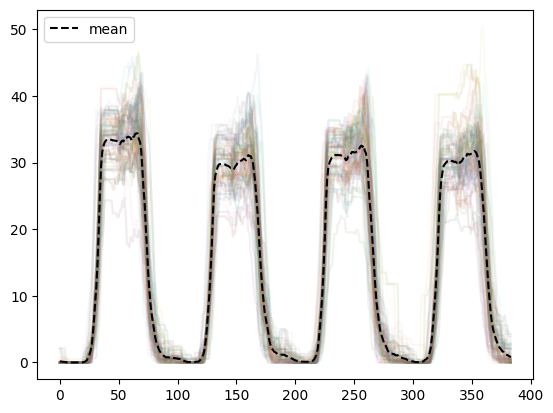

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39936 entries, 2020-11-09 00:00:00 to 2022-11-03 23:45:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   power_noscale  39936 non-null  float64
 1   power          39936 non-null  float64
 2   weekday        39936 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


,power_noscale,power,weekday
count,39936.000000,39936.000000,39936.00000
mean,42.982910,14.311028,15.00000
std,43.218431,14.416855,11.18048
min,0.000000,0.000000,0.00000
25%,1.060901,0.352192,7.50000
50%,21.952133,7.227087,15.00000
75%,89.022601,29.674200,22.50000
max,151.292562,50.430854,30.00000


In [3]:
filename = 'train_JPL_4_mjw.csv'

df = pd.read_csv(run_dir+'dati/'+filename,index_col=0,parse_dates=True)[:'2022-11-6'].fillna(method='ffill')

# dataset = pd.read_csv('dati/'+filename,sep=';')
# dataset['times_utc'] = pd.to_datetime(dataset['times_utc'], format=file_opt['dt_format'])
# dataset.set_index('times_utc', inplace=True)
#dataset = dataset.resample('15min').mean()

n_days = 4
dataset = df[df.index.weekday < n_days].dropna()

plot_overlaid(dataset.power,ppd=96,n_days=n_days,alpha=0.06)
dataset.info()
dataset.describe()

Persistence 1wk - all days

In [4]:
persit_days = 7

alldays = df
split = int(data_opt['tr_per']*len(alldays))
test = alldays[split:]

print(f'MAE {((test.power - test.power.shift(96*persit_days)).dropna().abs()).mean():.2f}')
print(f'nMAE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna().abs()).mean():.3f}')
print(f'nMSE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna()**2).mean():.3f}')

MAE 2.98
nMAE 0.059
nMSE 0.015


Persistence 1wk - weekdays

In [5]:
persit_days = 5

weekdays = df[df.index.weekday<5]
split = int(data_opt['tr_per']*len(weekdays))
test = weekdays[split:]

print(f'MAE {((test.power - test.power.shift(96*persit_days)).dropna().abs()).mean():.2f}')
print(f'nMAE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna().abs()).mean():.3f}')
print(f'nMSE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna()**2).mean():.3f}')

MAE 3.86
nMAE 0.076
nMSE 0.021


Persistence 1d - week days

In [6]:
persit_days = 1

weekdays = df[df.index.weekday<5]
split = int(data_opt['tr_per']*len(weekdays))
test = weekdays[split:]

print(f'MAE {((test.power - test.power.shift(96*persit_days)).dropna().abs()).mean():.2f}')
print(f'nMAE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna().abs()).mean():.3f}')
print(f'nMSE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna()**2).mean():.3f}')

MAE 4.06
nMAE 0.080
nMSE 0.020


Persistence 1wk - mon-thu

In [7]:
persit_days = 4

weekdays = df[df.index.weekday<4]
split = int(data_opt['tr_per']*len(weekdays))
test = weekdays[split:]

print(f'MAE {((test.power - test.power.shift(96*persit_days)).dropna().abs()).mean():.2f}')
print(f'nMAE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna().abs()).mean():.3f}')
print(f'nMSE {((test.power/dataset.power.max() - test.power.shift(96*persit_days)/dataset.power.max()).dropna()**2).mean():.3f}')

MAE 2.14
nMAE 0.043
nMSE 0.004


Persistence 1wk - fri

In [8]:
n_days = 1

weekdays = df[df.index.weekday==4]
split = int(data_opt['tr_per']*len(weekdays))
test = weekdays[split:]

print(f'MAE {((test.power - test.power.shift(96*n_days)).dropna().abs()).mean():.2f}')
print(f'nMAE {((test.power/dataset.power.max() - test.power.shift(96*n_days)/dataset.power.max()).dropna().abs()).mean():.3f}')
print(f'nMAE {((test.power/test.power.max() - test.power.shift(96*n_days)/test.power.max()).dropna().abs()).mean():.3f} (subset)')
print(f'nMSE {((test.power/dataset.power.max() - test.power.shift(96*n_days)/dataset.power.max()).dropna()**2).mean():.3f}')
print(f'nMSE {((test.power/test.power.max() - test.power.shift(96*n_days)/test.power.max()).dropna()**2).mean():.3f} (subset)')

MAE 10.34
nMAE 0.205
nMAE 0.257 (subset)
nMSE 0.082
nMSE 0.130 (subset)


Persistence 1wk - weekends

In [9]:
n_days = 2

weekends = df[df.index.weekday>4]
split = int(data_opt['tr_per']*len(weekends))
test = weekends[split:]

print(f'MAE {((test.power - test.power.shift(96*n_days)).dropna().abs()).mean():.2f}')
print(f'nMAE {((test.power/dataset.power.max() - test.power.shift(96*n_days)/dataset.power.max()).dropna().abs()).mean():.3f}')
print(f'nMAE {((test.power/test.power.max() - test.power.shift(96*n_days)/test.power.max()).dropna().abs()).mean():.3f} (subset)')
print(f'nMSE {((test.power/dataset.power.max() - test.power.shift(96*n_days)/dataset.power.max()).dropna()**2).mean():.3f}')
print(f'nMSE {((test.power/test.power.max() - test.power.shift(96*n_days)/test.power.max()).dropna()**2).mean():.3f} (subset)')

MAE 0.88
nMAE 0.017
nMAE 0.101 (subset)
nMSE 0.001
nMSE 0.030 (subset)


## Clean (optional)

The second block is run once for each month in the dataset to visually see outliers. 

Turn on plotly (first cell up top) to easily find the day-of-month to be replaced.

In [10]:
# year_month = '2020'

# plot_weekly(dataset.loc[year_month].power,alpha=0.3,begin_on_monday=False)
# dataset['weekday'] = dataset.index.weekday*10
# dataset[['weekday','power']].loc[year_month].plot()

In [11]:
# dataset.loc['2020-12-7':'2020-12-8']  = dataset.loc['2020-11-30':'2020-12-1'].values
# dataset.loc['2021-10-11':'2021-10-15']  = dataset.loc['2021-10-4':'2021-10-8'].values
# dataset.loc['2022-5-23':'2022-5-24']  = dataset.loc['2022-5-16':'2022-5-17'].values
# dataset.loc['2022-9-5':'2022-9-6']  = dataset.loc['2022-8-29':'2022-8-30'].values
# dataset.loc['2023-12-19':'2023-12-22']  = dataset.loc['2023-12-12':'2023-12-15'].values
# dataset.loc['2023-11-20']  = dataset.loc['2023-11-13'].values

# plot_weekly(dataset.power,title='train_JPL_4_mjw.csv Cleaned')
# dataset.to_csv('dati/train_JPL_4_mjw.csv')

## Shape

In [12]:
dataset['year'] = dataset.index.year
dataset['month'] = dataset.index.month
dataset['day'] = dataset.index.dayofweek
dataset['hour'] = dataset.index.hour
dataset['minute'] = dataset.index.minute

dataset = dataset[data_opt['columns']]

# print('data loaded')
train_X, train_y, test_X, test_y, scaler_X, scaler_y  = prepare_data(dataset, data_opt)
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1)) #solo ENC-DEC
# a = np.load('dati_veicoli/train_X.npy')

In [13]:
dump(scaler_X, open(model_opt["model_path"] + "scaler_in.pkl", 'wb'))
dump(scaler_y, open(model_opt["model_path"] + "scaler_out.pkl", 'wb'))

# Model

## Build

In [14]:
# smltn_chr = 'forecast'

with open(model_opt['model_path'] + 'Param.txt', 'w') as convert_file:
    convert_file.write(json.dumps(data_opt))
    convert_file.write(json.dumps(model_opt))

## Train

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 288, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 288, 128),           66560     ['input_1[0][0]']             
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                                  
 attention (attention)       (None, 128)                  416       ['lstm[0][0]']                
                                                                                              

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


889/889 [==============================] - 170s 189ms/step - loss: 0.0256 - val_loss: 0.0055
Epoch 2/200
889/889 [==============================] - 167s 188ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 3/200
889/889 [==============================] - 167s 188ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 4/200
889/889 [==============================] - 170s 192ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 5/200
889/889 [==============================] - 173s 195ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 6/200
889/889 [==============================] - 173s 195ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 7/200
889/889 [==============================] - 173s 195ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 8/200
889/889 [==============================] - 172s 194ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 9/200
889/889 [==============================] - 174s 196ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/200
889/889 [==============================] - 172s 194ms/

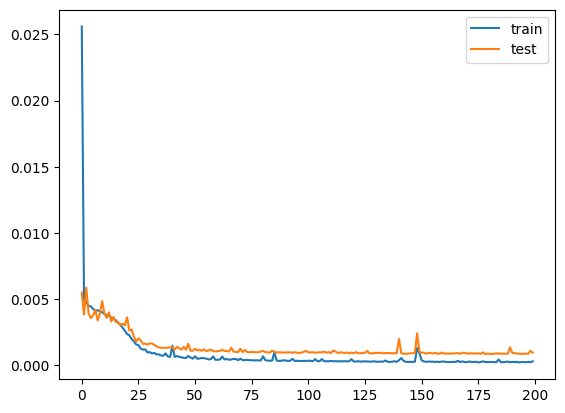

In [15]:
model_create_load_tune= 'create' # tune , load
if model_create_load_tune == 'create':
    model, history = create_model_attention(model_opt, train_X, train_y)
    model.save(model_opt['model_path'] + 'model.h5')

    # plot history
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.savefig(model_opt['model_path'] + 'history.png')

# Analyze

## Load

In [16]:
scaler_X = load(open(model_opt["model_path"] + "scaler_in.pkl", 'rb')) 
scaler_y = load(open(model_opt["model_path"] + "scaler_out.pkl", 'rb'))

model = load_model(model_opt["model_path"] + 'model.h5', custom_objects={"attention": attention})

## Predict

In [17]:
# make a prediction
yhat_np = model.predict(test_X)
yhat_np = yhat_np.reshape((yhat_np.shape[0], yhat_np.shape[1]))

# invert scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat_np)

y_hat = pd.DataFrame(data=inv_yhat, columns=test_y.columns, index=test_y.index)

124/124 [==============================] - 8s 58ms/step


In [18]:
# save
y_hat.to_csv(f"{model_opt['model_path']}forecast.csv")
test_y.to_csv(f"{model_opt['model_path']}measures.csv")

In [19]:
# with open(model_opt['model_path'] + 'Errors.csv', 'a') as f:
#     mae = (abs(y_hat.values - test_y.values)).mean()
#     units = model_opt['LSTM_num_hidden_units'][0]
#     input_dim = model_opt['input_dim']
#     f.write(f'{mae},{input_dim},{mae}\n')

In [20]:
mae = (abs(y_hat.values - test_y.values)).mean()
print(mae)

2.1439572793635167


In [21]:
nmae = (abs(y_hat.values - test_y.values)).mean()/dataset.power.max()
print(nmae)

0.04251280930843481


In [22]:
nmse = (((y_hat.values - test_y.values)/dataset.power.max())**2).mean()
print(nmse)

0.004033750556984829


In [23]:
dataset[int(len(dataset)*0.9):]

,power
times_utc,
2022-08-24 09:30:00,32.962726
2022-08-24 09:45:00,32.962726
2022-08-24 10:00:00,32.962726
2022-08-24 10:15:00,32.962726
2022-08-24 10:30:00,32.962726
...,...
2022-11-03 22:45:00,0.407956
2022-11-03 23:00:00,0.407956
2022-11-03 23:15:00,0.407956


# Plot

## Full weeks

In [24]:
viz_horizon_h = 24
horizon_h = int(data_opt['n_timesteps']/4)

week = 0
while ((1+week)*672) < len(y_hat):
    idx = pd.date_range(y_hat.index[week*672],
                            periods=int(168/viz_horizon_h),
                            freq=f'{viz_horizon_h}h')

    out1_tplus = [f'out1(t+{t})' for t in range(4*viz_horizon_h)]

    y_hat_flat =   y_hat[out1_tplus].loc[idx].values.flatten()
    test_y_flat = test_y[out1_tplus].loc[idx].values.flatten()

    nmse = (((y_hat_flat/50.431 - test_y_flat/50.431)**2)).mean()
    mae = (np.mean(np.abs(y_hat_flat - test_y_flat)))

    t = pd.date_range(idx[0],periods=len(y_hat_flat),freq='15min')
    plt.figure(figsize=(10,5))
    plt.plot(t,y_hat_flat,label='y_hat')
    plt.plot(t,test_y_flat,label='y_test')
    plt.legend()
    plt.title(f'LSTM horizon = {horizon_h}h (showing first {viz_horizon_h}h), MAE = {mae:.1f} kW, nMSE = {nmse:.3f}')
    plt.savefig(f'Output_notebook/test_vs_predict_week{week}.png')

    week+=1

KeyError: "[Timestamp('2022-08-26 08:30:00'), Timestamp('2022-08-27 08:30:00'), Timestamp('2022-08-28 08:30:00')] not in index"

## Weekdays only

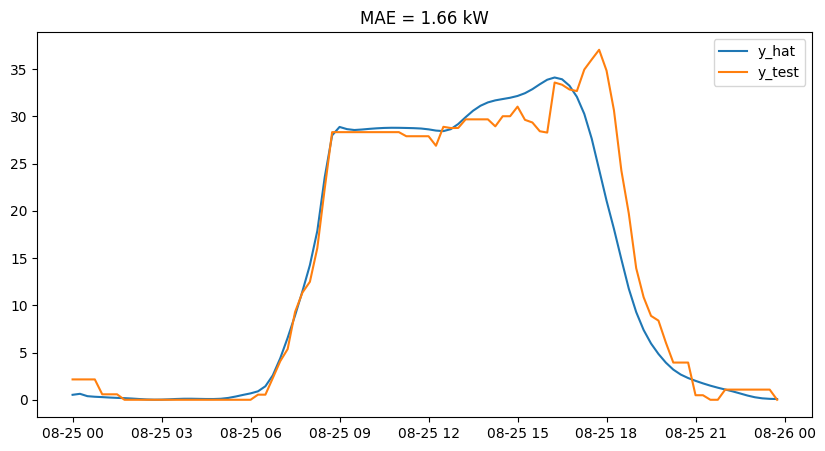

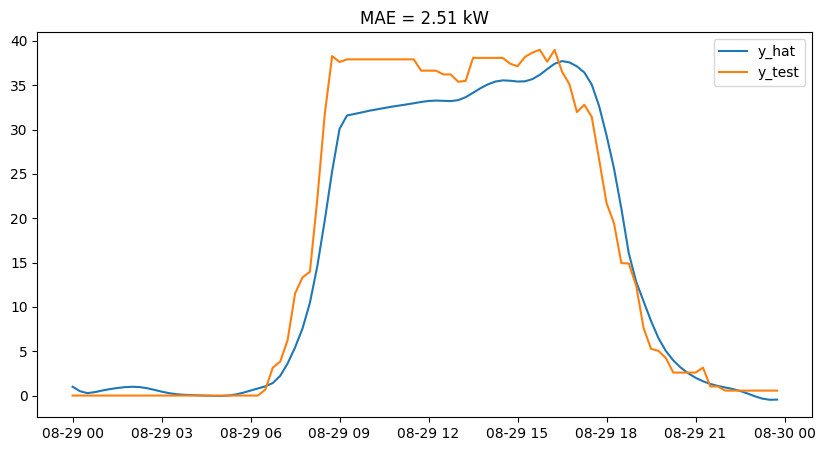

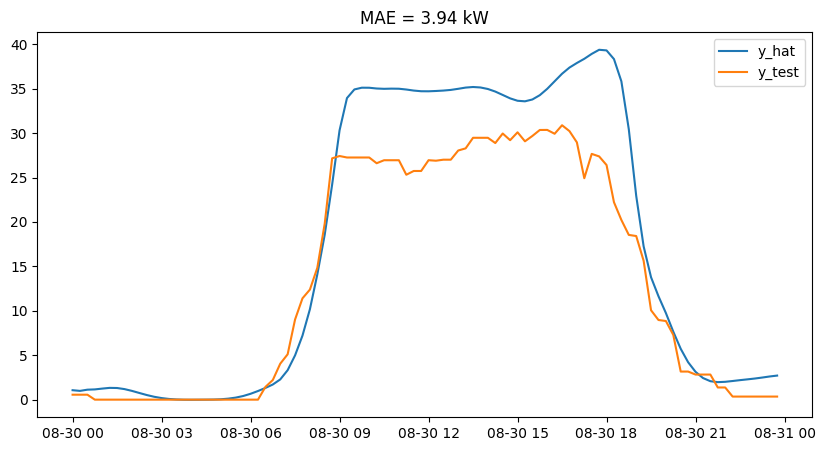

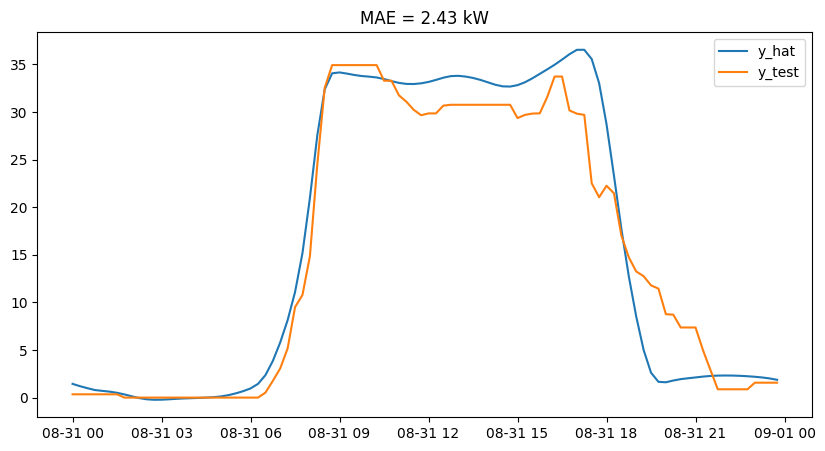

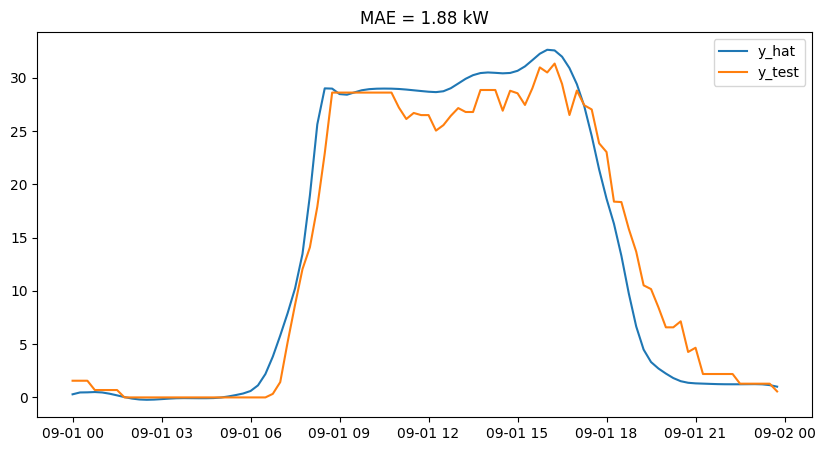

In [ ]:
y_hat = y_hat['2022-8-25':]
test_y = test_y['2022-8-25':]

for i in [x*96 for x in range(5)]:
    #i=0
    y_hat_flat = y_hat.iloc[i,:96].values
    test_y_flat = test_y.iloc[i,:96].values
    mae = ((abs(y_hat_flat - test_y_flat))).mean()
    t = pd.date_range(y_hat.index[i],periods=len(y_hat_flat),freq='15min')
    plt.figure(figsize=(10,5))
    plt.plot(t,y_hat_flat,label='y_hat')
    plt.plot(t,test_y_flat,label='y_test')
    plt.legend()
    plt.title(f'MAE = {mae:.2f} kW')

# Grid search

In [ ]:
# results file
errors_filepath = model_opt['model_path']+'Errors '+current_time.strftime("%Y-%m-%d")+'.csv'
with open(errors_filepath, 'w') as f:
    f.write('units1,units2,input_dim,mae\n')
    
    
# grid search
for units in [12,24,48,96,128,256]:
    units = [units,units]
    for input_dim in [24,48,96,144,192,288,672]:
        data_opt['n_back'] = input_dim
        model_opt['LSTM_num_hidden_units'] = units
        model_opt['input_dim'] = (data_opt['n_back'], data_opt['n_features'])

        # train
        model_create_load_tune= 'create' # tune , load
        if model_create_load_tune == 'create':
            model, history = create_model_attention(model_opt, train_X, train_y)
            model.save(model_opt['model_path'] + 'model.h5')

        # reload
        scaler_X = load(open(model_opt["model_path"] + "scaler_in.pkl", 'rb')) 
        scaler_y = load(open(model_opt["model_path"] + "scaler_out.pkl", 'rb'))
        model = load_model(model_opt["model_path"] + 'model.h5', custom_objects={"attention": attention})

        # make a prediction
        yhat_np = model.predict(test_X)
        yhat_np = yhat_np.reshape((yhat_np.shape[0], yhat_np.shape[1]))

        # invert scaling for forecast
        inv_yhat = scaler_y.inverse_transform(yhat_np)

        y_hat = pd.DataFrame(data=inv_yhat, columns=test_y.columns, index=test_y.index)

        # save errors
        with open(errors_filepath, 'a') as f:
            mae = (abs(y_hat.values - test_y.values)).mean()
            units1=units[0]
            units2=units[1]
            f.write(f'{units1},{units2},{input_dim},{mae}\n')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 96, 12),             672       ['input_1[0][0]']             
                              (None, 12),                                                         
                              (None, 12)]                                                         
                                                                                                  
 attention (attention)       (None, 12)                   108       ['lstm[0][0]']                
                                                                                              

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 58s 41ms/step - loss: 0.0285 - val_loss: 0.0129
Epoch 2/50
1336/1336 [==============================] - 54s 40ms/step - loss: 0.0102 - val_loss: 0.0121
Epoch 3/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 4/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0095 - val_loss: 0.0109
Epoch 5/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 6/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0093 - val_loss: 0.0106
Epoch 7/50
1336/1336 [==============================] - 51s 39ms/step - loss: 0.0091 - val_loss: 0.0105
Epoch 8/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 9/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 10/50
1336/1336 [==============================] - 51s 38ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 54s 39ms/step - loss: 0.0297 - val_loss: 0.0129
Epoch 2/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0101 - val_loss: 0.0116
Epoch 3/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0098 - val_loss: 0.0116
Epoch 4/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0096 - val_loss: 0.0112
Epoch 5/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0095 - val_loss: 0.0110
Epoch 6/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0094 - val_loss: 0.0121
Epoch 7/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0093 - val_loss: 0.0109
Epoch 8/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 9/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0090 - val_loss: 0.0114
Epoch 10/50
1336/1336 [==============================] - 51s 38ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 55s 39ms/step - loss: 0.0254 - val_loss: 0.0121
Epoch 2/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0101 - val_loss: 0.0118
Epoch 3/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0097 - val_loss: 0.0113
Epoch 4/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0096 - val_loss: 0.0113
Epoch 5/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0094 - val_loss: 0.0112
Epoch 6/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 7/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0092 - val_loss: 0.0105
Epoch 8/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 9/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 10/50
1336/1336 [==============================] - 51s 38ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 55s 39ms/step - loss: 0.0292 - val_loss: 0.0120
Epoch 2/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0102 - val_loss: 0.0110
Epoch 3/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0097 - val_loss: 0.0111
Epoch 4/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0095 - val_loss: 0.0112
Epoch 5/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 6/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0092 - val_loss: 0.0109
Epoch 7/50
1336/1336 [==============================] - 51s 39ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 8/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0089 - val_loss: 0.0114
Epoch 9/50
1336/1336 [==============================] - 51s 39ms/step - loss: 0.0088 - val_loss: 0.0112
Epoch 10/50
1336/1336 [==============================] - 52s 39ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 55s 39ms/step - loss: 0.0470 - val_loss: 0.0166
Epoch 2/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0120 - val_loss: 0.0126
Epoch 3/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0105 - val_loss: 0.0116
Epoch 4/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 5/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 6/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0097 - val_loss: 0.0112
Epoch 7/50
1336/1336 [==============================] - 50s 38ms/step - loss: 0.0095 - val_loss: 0.0114
Epoch 8/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0094 - val_loss: 0.0108
Epoch 9/50
1336/1336 [==============================] - 51s 38ms/step - loss: 0.0091 - val_loss: 0.0111
Epoch 10/50
1336/1336 [==============================] - 52s 39ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 55s 39ms/step - loss: 0.0290 - val_loss: 0.0123
Epoch 2/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0103 - val_loss: 0.0121
Epoch 3/50
1336/1336 [==============================] - 51s 39ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 4/50
1336/1336 [==============================] - 53s 39ms/step - loss: 0.0095 - val_loss: 0.0120
Epoch 5/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0095 - val_loss: 0.0109
Epoch 6/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 7/50
1336/1336 [==============================] - 53s 39ms/step - loss: 0.0093 - val_loss: 0.0109
Epoch 8/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0091 - val_loss: 0.0107
Epoch 9/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 10/50
1336/1336 [==============================] - 52s 39ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 58s 41ms/step - loss: 0.0258 - val_loss: 0.0120
Epoch 2/50
1336/1336 [==============================] - 54s 41ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 3/50
1336/1336 [==============================] - 55s 41ms/step - loss: 0.0096 - val_loss: 0.0113
Epoch 4/50
1336/1336 [==============================] - 54s 41ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 5/50
1336/1336 [==============================] - 55s 41ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 6/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0090 - val_loss: 0.0104
Epoch 7/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 8/50
1336/1336 [==============================] - 52s 39ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 9/50
1336/1336 [==============================] - 51s 39ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 10/50
1336/1336 [==============================] - 52s 39ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 63s 45ms/step - loss: 0.0229 - val_loss: 0.0119
Epoch 2/50
1336/1336 [==============================] - 60s 45ms/step - loss: 0.0099 - val_loss: 0.0112
Epoch 3/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0094 - val_loss: 0.0108
Epoch 4/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 5/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 6/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 7/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0086 - val_loss: 0.0100
Epoch 8/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0085 - val_loss: 0.0103
Epoch 9/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0085 - val_loss: 0.0100
Epoch 10/50
1336/1336 [==============================] - 59s 44ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 62s 45ms/step - loss: 0.0267 - val_loss: 0.0122
Epoch 2/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 3/50
1336/1336 [==============================] - 56s 42ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 4/50
1336/1336 [==============================] - 56s 42ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 5/50
1336/1336 [==============================] - 56s 42ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 6/50
1336/1336 [==============================] - 56s 42ms/step - loss: 0.0086 - val_loss: 0.0104
Epoch 7/50
1336/1336 [==============================] - 56s 42ms/step - loss: 0.0085 - val_loss: 0.0101
Epoch 8/50
1336/1336 [==============================] - 56s 42ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 9/50
1336/1336 [==============================] - 56s 42ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 10/50
1336/1336 [==============================] - 56s 42ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 61s 44ms/step - loss: 0.0224 - val_loss: 0.0122
Epoch 2/50
1336/1336 [==============================] - 58s 43ms/step - loss: 0.0098 - val_loss: 0.0113
Epoch 3/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0094 - val_loss: 0.0105
Epoch 4/50
1336/1336 [==============================] - 58s 44ms/step - loss: 0.0091 - val_loss: 0.0114
Epoch 5/50
1336/1336 [==============================] - 58s 43ms/step - loss: 0.0089 - val_loss: 0.0102
Epoch 6/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0087 - val_loss: 0.0110
Epoch 7/50
1336/1336 [==============================] - 58s 43ms/step - loss: 0.0085 - val_loss: 0.0100
Epoch 8/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 9/50
1336/1336 [==============================] - 58s 44ms/step - loss: 0.0081 - val_loss: 0.0098
Epoch 10/50
1336/1336 [==============================] - 58s 44ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 61s 44ms/step - loss: 0.0246 - val_loss: 0.0114
Epoch 2/50
1336/1336 [==============================] - 58s 44ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 3/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 4/50
1336/1336 [==============================] - 58s 44ms/step - loss: 0.0092 - val_loss: 0.0120
Epoch 5/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0090 - val_loss: 0.0115
Epoch 6/50
1336/1336 [==============================] - 58s 43ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 7/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 8/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 9/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0083 - val_loss: 0.0103
Epoch 10/50
1336/1336 [==============================] - 59s 44ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 61s 43ms/step - loss: 0.0260 - val_loss: 0.0131
Epoch 2/50
1336/1336 [==============================] - 60s 45ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 3/50
1336/1336 [==============================] - 59s 44ms/step - loss: 0.0095 - val_loss: 0.0109
Epoch 4/50
1336/1336 [==============================] - 60s 45ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 5/50
1336/1336 [==============================] - 59s 45ms/step - loss: 0.0090 - val_loss: 0.0101
Epoch 6/50
1336/1336 [==============================] - 59s 45ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 7/50
1336/1336 [==============================] - 60s 45ms/step - loss: 0.0086 - val_loss: 0.0105
Epoch 8/50
1336/1336 [==============================] - 60s 45ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 9/50
1336/1336 [==============================] - 60s 45ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 10/50
1336/1336 [==============================] - 59s 44ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 64s 46ms/step - loss: 0.0208 - val_loss: 0.0114
Epoch 2/50
1336/1336 [==============================] - 61s 46ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 3/50
1336/1336 [==============================] - 61s 45ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 4/50
1336/1336 [==============================] - 61s 46ms/step - loss: 0.0091 - val_loss: 0.0112
Epoch 5/50
1336/1336 [==============================] - 61s 45ms/step - loss: 0.0089 - val_loss: 0.0112
Epoch 6/50
1336/1336 [==============================] - 61s 46ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 7/50
1336/1336 [==============================] - 61s 46ms/step - loss: 0.0086 - val_loss: 0.0101
Epoch 8/50
1336/1336 [==============================] - 61s 46ms/step - loss: 0.0084 - val_loss: 0.0112
Epoch 9/50
1336/1336 [==============================] - 61s 45ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 10/50
1336/1336 [==============================] - 59s 44ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 65s 46ms/step - loss: 0.0306 - val_loss: 0.0118
Epoch 2/50
1336/1336 [==============================] - 62s 46ms/step - loss: 0.0101 - val_loss: 0.0117
Epoch 3/50
1336/1336 [==============================] - 61s 46ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 4/50
1336/1336 [==============================] - 61s 46ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 5/50
1336/1336 [==============================] - 60s 45ms/step - loss: 0.0092 - val_loss: 0.0105
Epoch 6/50
1336/1336 [==============================] - 58s 44ms/step - loss: 0.0089 - val_loss: 0.0105
Epoch 7/50
1336/1336 [==============================] - 58s 43ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 8/50
1336/1336 [==============================] - 58s 43ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 9/50
1336/1336 [==============================] - 58s 44ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 10/50
1336/1336 [==============================] - 58s 43ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 88s 64ms/step - loss: 0.0188 - val_loss: 0.0126
Epoch 2/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0097 - val_loss: 0.0130
Epoch 3/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 4/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0088 - val_loss: 0.0108
Epoch 5/50
1336/1336 [==============================] - 84s 63ms/step - loss: 0.0086 - val_loss: 0.0102
Epoch 6/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0084 - val_loss: 0.0111
Epoch 7/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0081 - val_loss: 0.0102
Epoch 8/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0079 - val_loss: 0.0104
Epoch 9/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0076 - val_loss: 0.0102
Epoch 10/50
1336/1336 [==============================] - 85s 64ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 88s 64ms/step - loss: 0.0181 - val_loss: 0.0116
Epoch 2/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0097 - val_loss: 0.0114
Epoch 3/50
1336/1336 [==============================] - 86s 64ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 4/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 5/50
1336/1336 [==============================] - 86s 64ms/step - loss: 0.0086 - val_loss: 0.0104
Epoch 6/50
1336/1336 [==============================] - 86s 64ms/step - loss: 0.0083 - val_loss: 0.0101
Epoch 7/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0080 - val_loss: 0.0100
Epoch 8/50
1336/1336 [==============================] - 86s 64ms/step - loss: 0.0079 - val_loss: 0.0100
Epoch 9/50
1336/1336 [==============================] - 85s 64ms/step - loss: 0.0077 - val_loss: 0.0103
Epoch 10/50
1336/1336 [==============================] - 86s 64ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 91s 66ms/step - loss: 0.0205 - val_loss: 0.0115
Epoch 2/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 3/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch 4/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 5/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0086 - val_loss: 0.0104
Epoch 6/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0082 - val_loss: 0.0101
Epoch 7/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 8/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0078 - val_loss: 0.0096
Epoch 9/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 10/50
1336/1336 [==============================] - 87s 65ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 92s 67ms/step - loss: 0.0180 - val_loss: 0.0131
Epoch 2/50
1336/1336 [==============================] - 89s 66ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 3/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 4/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 5/50
1336/1336 [==============================] - 89s 66ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 6/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 7/50
1336/1336 [==============================] - 89s 66ms/step - loss: 0.0081 - val_loss: 0.0109
Epoch 8/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0079 - val_loss: 0.0106
Epoch 9/50
1336/1336 [==============================] - 89s 66ms/step - loss: 0.0078 - val_loss: 0.0104
Epoch 10/50
1336/1336 [==============================] - 89s 67ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 90s 66ms/step - loss: 0.0198 - val_loss: 0.0114
Epoch 2/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0097 - val_loss: 0.0125
Epoch 3/50
1336/1336 [==============================] - 88s 66ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 4/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0089 - val_loss: 0.0105
Epoch 5/50
1336/1336 [==============================] - 88s 66ms/step - loss: 0.0086 - val_loss: 0.0103
Epoch 6/50
1336/1336 [==============================] - 88s 65ms/step - loss: 0.0084 - val_loss: 0.0104
Epoch 7/50
1336/1336 [==============================] - 88s 66ms/step - loss: 0.0080 - val_loss: 0.0099
Epoch 8/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 9/50
1336/1336 [==============================] - 88s 66ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 10/50
1336/1336 [==============================] - 87s 65ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 91s 66ms/step - loss: 0.0226 - val_loss: 0.0110
Epoch 2/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0097 - val_loss: 0.0108
Epoch 3/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 4/50
1336/1336 [==============================] - 86s 65ms/step - loss: 0.0089 - val_loss: 0.0116
Epoch 5/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 6/50
1336/1336 [==============================] - 86s 64ms/step - loss: 0.0085 - val_loss: 0.0099
Epoch 7/50
1336/1336 [==============================] - 87s 65ms/step - loss: 0.0083 - val_loss: 0.0100
Epoch 8/50
1336/1336 [==============================] - 86s 64ms/step - loss: 0.0079 - val_loss: 0.0097
Epoch 9/50
1336/1336 [==============================] - 86s 65ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 10/50
1336/1336 [==============================] - 87s 65ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 92s 67ms/step - loss: 0.0231 - val_loss: 0.0112
Epoch 2/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0096 - val_loss: 0.0116
Epoch 3/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0092 - val_loss: 0.0101
Epoch 4/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 5/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 6/50
1336/1336 [==============================] - 90s 67ms/step - loss: 0.0084 - val_loss: 0.0097
Epoch 7/50
1336/1336 [==============================] - 89s 66ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 8/50
1336/1336 [==============================] - 89s 67ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 9/50
1336/1336 [==============================] - 88s 66ms/step - loss: 0.0077 - val_loss: 0.0103
Epoch 10/50
1336/1336 [==============================] - 89s 67ms/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 271s 200ms/step - loss: 0.0232 - val_loss: 0.0117
Epoch 2/50
1336/1336 [==============================] - 271s 203ms/step - loss: 0.0099 - val_loss: 0.0113
Epoch 3/50
1336/1336 [==============================] - 340s 255ms/step - loss: 0.0094 - val_loss: 0.0110
Epoch 4/50
1336/1336 [==============================] - 349s 261ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 5/50
1336/1336 [==============================] - 349s 261ms/step - loss: 0.0086 - val_loss: 0.0103
Epoch 6/50
1336/1336 [==============================] - 349s 261ms/step - loss: 0.0083 - val_loss: 0.0104
Epoch 7/50
1336/1336 [==============================] - 348s 261ms/step - loss: 0.0081 - val_loss: 0.0103
Epoch 8/50
1336/1336 [==============================] - 350s 262ms/step - loss: 0.0079 - val_loss: 0.0105
Epoch 9/50
1336/1336 [==============================] - 349s 261ms/step - loss: 0.0077 - val_loss: 0.0101
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 334s 248ms/step - loss: 0.0220 - val_loss: 0.0107
Epoch 2/50
1336/1336 [==============================] - 330s 247ms/step - loss: 0.0098 - val_loss: 0.0119
Epoch 3/50
1336/1336 [==============================] - 330s 247ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 4/50
1336/1336 [==============================] - 331s 248ms/step - loss: 0.0089 - val_loss: 0.0112
Epoch 5/50
1336/1336 [==============================] - 329s 247ms/step - loss: 0.0086 - val_loss: 0.0101
Epoch 6/50
1336/1336 [==============================] - 327s 245ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 7/50
1336/1336 [==============================] - 328s 246ms/step - loss: 0.0080 - val_loss: 0.0099
Epoch 8/50
1336/1336 [==============================] - 328s 245ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 9/50
1336/1336 [==============================] - 329s 246ms/step - loss: 0.0078 - val_loss: 0.0116
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 327s 243ms/step - loss: 0.0341 - val_loss: 0.0117
Epoch 2/50
1336/1336 [==============================] - 326s 244ms/step - loss: 0.0101 - val_loss: 0.0115
Epoch 3/50
1336/1336 [==============================] - 323s 242ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 4/50
1336/1336 [==============================] - 323s 242ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 5/50
1336/1336 [==============================] - 325s 243ms/step - loss: 0.0086 - val_loss: 0.0102
Epoch 6/50
1336/1336 [==============================] - 325s 243ms/step - loss: 0.0083 - val_loss: 0.0105
Epoch 7/50
1336/1336 [==============================] - 324s 243ms/step - loss: 0.0082 - val_loss: 0.0103
Epoch 8/50
1336/1336 [==============================] - 325s 244ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 9/50
1336/1336 [==============================] - 325s 244ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 317s 235ms/step - loss: 0.0203 - val_loss: 0.0127
Epoch 2/50
1336/1336 [==============================] - 313s 235ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 3/50
1336/1336 [==============================] - 311s 232ms/step - loss: 0.0093 - val_loss: 0.0104
Epoch 4/50
1336/1336 [==============================] - 310s 232ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 5/50
1336/1336 [==============================] - 311s 233ms/step - loss: 0.0085 - val_loss: 0.0103
Epoch 6/50
1336/1336 [==============================] - 311s 233ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 7/50
1336/1336 [==============================] - 311s 233ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 8/50
1336/1336 [==============================] - 309s 232ms/step - loss: 0.0077 - val_loss: 0.0103
Epoch 9/50
1336/1336 [==============================] - 310s 232ms/step - loss: 0.0074 - val_loss: 0.0113
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 328s 244ms/step - loss: 0.0179 - val_loss: 0.0109
Epoch 2/50
1336/1336 [==============================] - 326s 244ms/step - loss: 0.0096 - val_loss: 0.0118
Epoch 3/50
1336/1336 [==============================] - 325s 244ms/step - loss: 0.0090 - val_loss: 0.0099
Epoch 4/50
1336/1336 [==============================] - 325s 244ms/step - loss: 0.0086 - val_loss: 0.0104
Epoch 5/50
1336/1336 [==============================] - 325s 244ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 6/50
1336/1336 [==============================] - 326s 244ms/step - loss: 0.0079 - val_loss: 0.0109
Epoch 7/50
1336/1336 [==============================] - 324s 243ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 8/50
1336/1336 [==============================] - 326s 244ms/step - loss: 0.0075 - val_loss: 0.0100
Epoch 9/50
1336/1336 [==============================] - 328s 245ms/step - loss: 0.0072 - val_loss: 0.0105
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 330s 245ms/step - loss: 0.0340 - val_loss: 0.0119
Epoch 2/50
1336/1336 [==============================] - 328s 245ms/step - loss: 0.0101 - val_loss: 0.0111
Epoch 3/50
1336/1336 [==============================] - 329s 246ms/step - loss: 0.0097 - val_loss: 0.0110
Epoch 4/50
1336/1336 [==============================] - 327s 245ms/step - loss: 0.0095 - val_loss: 0.0104
Epoch 5/50
1336/1336 [==============================] - 328s 245ms/step - loss: 0.0091 - val_loss: 0.0111
Epoch 6/50
1336/1336 [==============================] - 327s 245ms/step - loss: 0.0089 - val_loss: 0.0102
Epoch 7/50
1336/1336 [==============================] - 327s 245ms/step - loss: 0.0085 - val_loss: 0.0110
Epoch 8/50
1336/1336 [==============================] - 327s 244ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 9/50
1336/1336 [==============================] - 327s 245ms/step - loss: 0.0080 - val_loss: 0.0100
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 314s 233ms/step - loss: 0.0248 - val_loss: 0.0114
Epoch 2/50
1336/1336 [==============================] - 312s 234ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 3/50
1336/1336 [==============================] - 311s 233ms/step - loss: 0.0092 - val_loss: 0.0103
Epoch 4/50
1336/1336 [==============================] - 311s 233ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 5/50
1336/1336 [==============================] - 311s 233ms/step - loss: 0.0084 - val_loss: 0.0102
Epoch 6/50
1336/1336 [==============================] - 314s 235ms/step - loss: 0.0082 - val_loss: 0.0097
Epoch 7/50
1336/1336 [==============================] - 313s 234ms/step - loss: 0.0080 - val_loss: 0.0147
Epoch 8/50
1336/1336 [==============================] - 312s 233ms/step - loss: 0.0079 - val_loss: 0.0106
Epoch 9/50
1336/1336 [==============================] - 312s 234ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 433s 322ms/step - loss: 0.0286 - val_loss: 0.0118
Epoch 2/50
1336/1336 [==============================] - 427s 320ms/step - loss: 0.0102 - val_loss: 0.0117
Epoch 3/50
1336/1336 [==============================] - 430s 322ms/step - loss: 0.0097 - val_loss: 0.0108
Epoch 4/50
1336/1336 [==============================] - 428s 320ms/step - loss: 0.0090 - val_loss: 0.0111
Epoch 5/50
1336/1336 [==============================] - 431s 322ms/step - loss: 0.0086 - val_loss: 0.0103
Epoch 6/50
1336/1336 [==============================] - 429s 321ms/step - loss: 0.0083 - val_loss: 0.0100
Epoch 7/50
1336/1336 [==============================] - 430s 322ms/step - loss: 0.0080 - val_loss: 0.0110
Epoch 8/50
1336/1336 [==============================] - 430s 322ms/step - loss: 0.0077 - val_loss: 0.0104
Epoch 9/50
1336/1336 [==============================] - 441s 330ms/step - loss: 0.0076 - val_loss: 0.0104
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 416s 310ms/step - loss: 0.0172 - val_loss: 0.0110
Epoch 2/50
1336/1336 [==============================] - 407s 304ms/step - loss: 0.0097 - val_loss: 0.0106
Epoch 3/50
1336/1336 [==============================] - 405s 303ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 4/50
1336/1336 [==============================] - 407s 305ms/step - loss: 0.0086 - val_loss: 0.0101
Epoch 5/50
1336/1336 [==============================] - 405s 303ms/step - loss: 0.0082 - val_loss: 0.0110
Epoch 6/50
1336/1336 [==============================] - 407s 305ms/step - loss: 0.0079 - val_loss: 0.0101
Epoch 7/50
1336/1336 [==============================] - 407s 305ms/step - loss: 0.0076 - val_loss: 0.0106
Epoch 8/50
1336/1336 [==============================] - 404s 302ms/step - loss: 0.0073 - val_loss: 0.0107
Epoch 9/50
1336/1336 [==============================] - 406s 304ms/step - loss: 0.0070 - val_loss: 0.0101
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 382s 284ms/step - loss: 0.0180 - val_loss: 0.0117
Epoch 2/50
1336/1336 [==============================] - 376s 281ms/step - loss: 0.0097 - val_loss: 0.0113
Epoch 3/50
1336/1336 [==============================] - 378s 283ms/step - loss: 0.0090 - val_loss: 0.0102
Epoch 4/50
1336/1336 [==============================] - 378s 283ms/step - loss: 0.0085 - val_loss: 0.0098
Epoch 5/50
1336/1336 [==============================] - 377s 283ms/step - loss: 0.0082 - val_loss: 0.0107
Epoch 6/50
1336/1336 [==============================] - 378s 283ms/step - loss: 0.0080 - val_loss: 0.0106
Epoch 7/50
1336/1336 [==============================] - 377s 282ms/step - loss: 0.0079 - val_loss: 0.0108
Epoch 8/50
1336/1336 [==============================] - 381s 285ms/step - loss: 0.0076 - val_loss: 0.0104
Epoch 9/50
1336/1336 [==============================] - 380s 284ms/step - loss: 0.0074 - val_loss: 0.0099
Epoch 9: early stopping
186/186 [========================

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 289s 214ms/step - loss: 0.0182 - val_loss: 0.0112
Epoch 2/50
1336/1336 [==============================] - 286s 214ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 3/50
1336/1336 [==============================] - 285s 214ms/step - loss: 0.0090 - val_loss: 0.0107
Epoch 4/50
1336/1336 [==============================] - 286s 214ms/step - loss: 0.0085 - val_loss: 0.0105
Epoch 5/50
1336/1336 [==============================] - 286s 214ms/step - loss: 0.0083 - val_loss: 0.0099
Epoch 6/50
1336/1336 [==============================] - 284s 212ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 7/50
1336/1336 [==============================] - 286s 214ms/step - loss: 0.0077 - val_loss: 0.0100
Epoch 8/50
1336/1336 [==============================] - 286s 214ms/step - loss: 0.0074 - val_loss: 0.0102
Epoch 9/50
1336/1336 [==============================] - 285s 214ms/step - loss: 0.0070 - val_loss: 0.0101
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 302s 224ms/step - loss: 0.0171 - val_loss: 0.0107
Epoch 2/50
1336/1336 [==============================] - 298s 223ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 3/50
1336/1336 [==============================] - 298s 223ms/step - loss: 0.0090 - val_loss: 0.0101
Epoch 4/50
1336/1336 [==============================] - 299s 224ms/step - loss: 0.0086 - val_loss: 0.0101
Epoch 5/50
1336/1336 [==============================] - 298s 223ms/step - loss: 0.0083 - val_loss: 0.0101
Epoch 6/50
1336/1336 [==============================] - 298s 223ms/step - loss: 0.0079 - val_loss: 0.0106
Epoch 7/50
1336/1336 [==============================] - 299s 224ms/step - loss: 0.0076 - val_loss: 0.0104
Epoch 8/50
1336/1336 [==============================] - 298s 223ms/step - loss: 0.0074 - val_loss: 0.0113
Epoch 9/50
1336/1336 [==============================] - 298s 223ms/step - loss: 0.0070 - val_loss: 0.0107
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 291s 216ms/step - loss: 0.0262 - val_loss: 0.0111
Epoch 2/50
1336/1336 [==============================] - 293s 219ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 3/50
1336/1336 [==============================] - 294s 220ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 4/50
1336/1336 [==============================] - 294s 220ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 5/50
1336/1336 [==============================] - 294s 220ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 6/50
1336/1336 [==============================] - 295s 221ms/step - loss: 0.0080 - val_loss: 0.0102
Epoch 7/50
1336/1336 [==============================] - 295s 220ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 8/50
1336/1336 [==============================] - 293s 219ms/step - loss: 0.0075 - val_loss: 0.0101
Epoch 9/50
1336/1336 [==============================] - 294s 220ms/step - loss: 0.0072 - val_loss: 0.0109
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 293s 217ms/step - loss: 0.0186 - val_loss: 0.0119
Epoch 2/50
1336/1336 [==============================] - 288s 216ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 3/50
1336/1336 [==============================] - 288s 215ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 4/50
1336/1336 [==============================] - 289s 216ms/step - loss: 0.0085 - val_loss: 0.0109
Epoch 5/50
1336/1336 [==============================] - 288s 216ms/step - loss: 0.0083 - val_loss: 0.0104
Epoch 6/50
1336/1336 [==============================] - 287s 215ms/step - loss: 0.0080 - val_loss: 0.0102
Epoch 7/50
1336/1336 [==============================] - 289s 216ms/step - loss: 0.0078 - val_loss: 0.0104
Epoch 8/50
1336/1336 [==============================] - 288s 216ms/step - loss: 0.0075 - val_loss: 0.0106
Epoch 9/50
1336/1336 [==============================] - 287s 215ms/step - loss: 0.0072 - val_loss: 0.0102
Epoch 10/50
1336/1336 [==============================] - 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 1866s 1s/step - loss: 0.0672 - val_loss: 0.0130
Epoch 2/50
1336/1336 [==============================] - 1896s 1s/step - loss: 0.0104 - val_loss: 0.0111
Epoch 3/50
1336/1336 [==============================] - 1919s 1s/step - loss: 0.0093 - val_loss: 0.0105
Epoch 4/50
1336/1336 [==============================] - 1909s 1s/step - loss: 0.0086 - val_loss: 0.0103
Epoch 5/50
1336/1336 [==============================] - 1916s 1s/step - loss: 0.0083 - val_loss: 0.0098
Epoch 6/50
1336/1336 [==============================] - 1897s 1s/step - loss: 0.0080 - val_loss: 0.0107
Epoch 7/50
1336/1336 [==============================] - 1910s 1s/step - loss: 0.0077 - val_loss: 0.0122
Epoch 8/50
1336/1336 [==============================] - 1932s 1s/step - loss: 0.0073 - val_loss: 0.0099
Epoch 9/50
1336/1336 [==============================] - 1947s 1s/step - loss: 0.0068 - val_loss: 0.0103
Epoch 10/50
1336/1336 [==============================] - 1916s 1s/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 1752s 1s/step - loss: 0.0448 - val_loss: 0.0115
Epoch 2/50
1336/1336 [==============================] - 1741s 1s/step - loss: 0.0101 - val_loss: 0.0105
Epoch 3/50
1336/1336 [==============================] - 1729s 1s/step - loss: 0.0092 - val_loss: 0.0105
Epoch 4/50
1336/1336 [==============================] - 1709s 1s/step - loss: 0.0087 - val_loss: 0.0106
Epoch 5/50
1336/1336 [==============================] - 1713s 1s/step - loss: 0.0083 - val_loss: 0.0101
Epoch 6/50
1336/1336 [==============================] - 1709s 1s/step - loss: 0.0079 - val_loss: 0.0103
Epoch 7/50
1336/1336 [==============================] - 1710s 1s/step - loss: 0.0075 - val_loss: 0.0102
Epoch 8/50
1336/1336 [==============================] - 1702s 1s/step - loss: 0.0071 - val_loss: 0.0112
Epoch 9/50
1336/1336 [==============================] - 1710s 1s/step - loss: 0.0068 - val_loss: 0.0105
Epoch 10/50
1336/1336 [==============================] - 1706s 1s/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 1746s 1s/step - loss: 0.0456 - val_loss: 0.0121
Epoch 2/50
1336/1336 [==============================] - 1734s 1s/step - loss: 0.0102 - val_loss: 0.0112
Epoch 3/50
1336/1336 [==============================] - 1759s 1s/step - loss: 0.0094 - val_loss: 0.0099
Epoch 4/50
1336/1336 [==============================] - 1723s 1s/step - loss: 0.0088 - val_loss: 0.0101
Epoch 5/50
1336/1336 [==============================] - 1724s 1s/step - loss: 0.0084 - val_loss: 0.0106
Epoch 6/50
1336/1336 [==============================] - 1747s 1s/step - loss: 0.0081 - val_loss: 0.0098
Epoch 7/50
1336/1336 [==============================] - 1837s 1s/step - loss: 0.0077 - val_loss: 0.0099
Epoch 8/50
1336/1336 [==============================] - 1835s 1s/step - loss: 0.0073 - val_loss: 0.0100
Epoch 9/50
1336/1336 [==============================] - 1829s 1s/step - loss: 0.0068 - val_loss: 0.0103
Epoch 10/50
1336/1336 [==============================] - 1830s 1s/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 1700s 1s/step - loss: 0.0427 - val_loss: 0.0123
Epoch 2/50
1336/1336 [==============================] - 1665s 1s/step - loss: 0.0103 - val_loss: 0.0111
Epoch 3/50
1336/1336 [==============================] - 1673s 1s/step - loss: 0.0095 - val_loss: 0.0124
Epoch 4/50
1336/1336 [==============================] - 1674s 1s/step - loss: 0.0089 - val_loss: 0.0138
Epoch 5/50
1336/1336 [==============================] - 1677s 1s/step - loss: 0.0087 - val_loss: 0.0101
Epoch 6/50
1336/1336 [==============================] - 1673s 1s/step - loss: 0.0084 - val_loss: 0.0106
Epoch 7/50
1336/1336 [==============================] - 1676s 1s/step - loss: 0.0082 - val_loss: 0.0103
Epoch 8/50
1336/1336 [==============================] - 1674s 1s/step - loss: 0.0077 - val_loss: 0.0106
Epoch 9/50
1336/1336 [==============================] - 1668s 1s/step - loss: 0.0074 - val_loss: 0.0101
Epoch 10/50
1336/1336 [==============================] - 1664s 1s/step - lo

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 1740s 1s/step - loss: 0.0400 - val_loss: 0.0112
Epoch 2/50
1336/1336 [==============================] - 1745s 1s/step - loss: 0.0102 - val_loss: 0.0108
Epoch 3/50
1336/1336 [==============================] - 1740s 1s/step - loss: 0.0095 - val_loss: 0.0103
Epoch 4/50
 556/1336 [===========>..................] - ETA: 16:18 - loss: 0.0091

KeyboardInterrupt: 